In [1]:
import sys
sys.path.append("../core-scripts")
import ShearSpectrum3D
import ShearSpectrum3DFull as S3D
import zeroShearSpectrum3D as ZeroShearSpectrum3D
import incompressZeroShearSpectrum3D as IncS3D
import Utilities
from cheb import cheb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os

In [15]:
kx, kz = 1.0, 0.3
gd = 0.6
a = 0.7
M=170

evals_3D, emodes_3D = S3D.spectrum(kx, kz, gd, a, M=M)
# evals_3D, emodes_3D = ShearSpectrum3D.spectrum(kx, 0.1, gd, a, M=M)

Eigenvalue: (-0.7231-1.0034j)
(1360, 840)


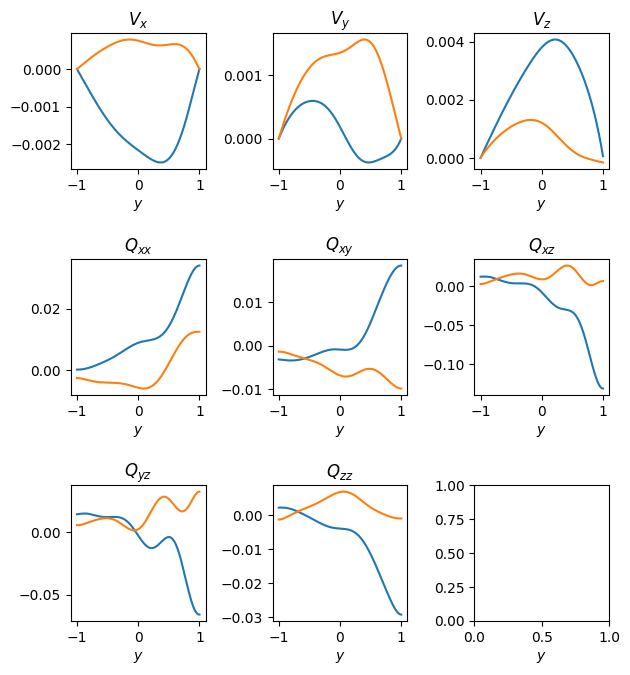

In [20]:
_, Y = cheb(M)
sort_idx = np.argsort(-np.real(evals_3D))
evals_3D = evals_3D[sort_idx]
emodes_3D = emodes_3D[:,sort_idx]
mode = 3
fig = Utilities.plot_modes(mode, Y, emodes_3D, M)
fig.set_figheight(7)

with np.printoptions(precision=3, suppress=True):
    print("Eigenvalue:", np.round(evals_3D[mode],4))
print(emodes_3D.shape)

### Following Boyd 7.5, we calculate two different scaled difference measures between the spectra at different resolutions. They are given by

$$ \delta^o_j = |\lambda_j(M_1) - \lambda_j(M_2)| / \sigma_j$$
$$ \delta^n_j = \min_k|\lambda_j(M_1) - \lambda_k(M_2)| / \sigma_j$$
where 
$$\sigma_j = \min(|\lambda_j|, \frac{|\lambda_j - \lambda_{j-1}| + |\lambda_{j+1} - \lambda_j|}{2}) $$

### We can only be sure that the spectra at different resolutions are well-resolved when $\delta^o_j \approx \delta^n_j$, because that means the solution didn't suddenly change when we changed the resolution.

Calculate the spectrum

In [13]:
kx, kz, gd, a = 0.5, 0.6, 0.87, 1.3
low_evals, _ = S3D.spectrum(kx, kz, gd, a, M=170)
high_evals, high_modes = S3D.spectrum(kx, kz, gd, a, M=200)
low_evals = low_evals[np.argsort(-np.real(low_evals))]
high_evals = high_evals[np.argsort(-np.real(high_evals))]

Remove leading spurious eigenvalues, and plot scaled differences

70 70
Resolultion Score: 0.49152542372881375


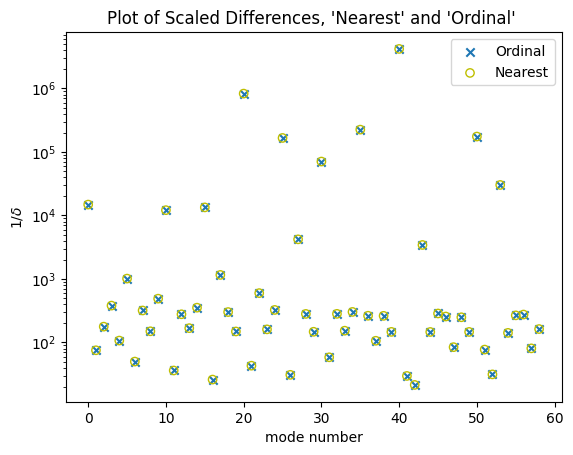

In [14]:
_, ptr1, ptr2 = Utilities.prune_evs(low_evals, high_evals, eps=1e-5)
def real_err(ev1, ev2):
    # Only compare the 10 values near the pruning pointers
    return np.linalg.norm(ev1[:10].real-ev2[:10].real)

# Line up the spectra near the pruning pointers
curr_real_err = real_err(low_evals[ptr1:], high_evals[ptr2:])
ptr1_aux = ptr1
stop = False
while not stop:
    if real_err(low_evals[ptr1+1:], high_evals[ptr2:]) < curr_real_err:
        curr_real_err = real_err(low_evals[ptr1+1:], high_evals[ptr2:])
        ptr1_aux += 1
    elif real_err(low_evals[ptr1-1:], high_evals[ptr2:]) < curr_real_err:
        curr_real_err = real_err(low_evals[ptr1-1:], high_evals[ptr2:])
        ptr1_aux -= 1
    else:
        stop = True
print(ptr1, ptr1_aux)

fig, d_ordinal, d_nearest = Utilities.plot_scaled_diff(low_evals[ptr1_aux:ptr1_aux+60], high_evals[ptr2:ptr2+60])
resolve_score = 0
for i in range(len(d_ordinal)//2):
    if np.abs(d_ordinal[i] - d_nearest[i]) < 0.001:
        resolve_score += 1 / len(d_ordinal)
print("Resolultion Score:", resolve_score)

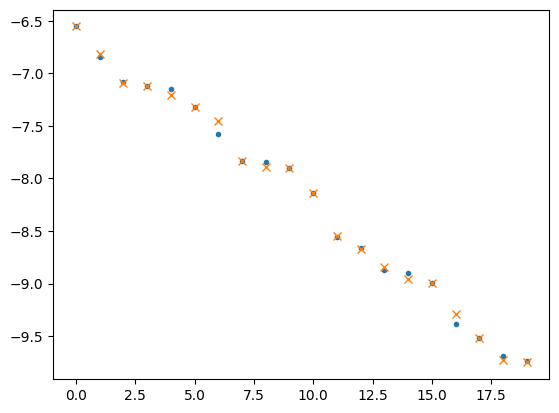

In [8]:
plt.plot(low_evals[ptr1_aux:ptr1_aux+20].real,'.')
plt.plot(high_evals[ptr2:ptr2+20].real,'x')

In [ ]:
low_evals = low_evals[np.where(low_evals.real<10)]
high_evals = high_evals[np.where(high_evals.real<10)]
pruned, ptr1, ptr2 = Utilities.prune_evs(low_evals, high_evals, eps=1e-3)

print(ptr1, ptr2)
print(low_evals[ptr1:ptr1+10])
print(high_evals[ptr2:ptr2+10])

print()
print(low_evals[0:10])
print(high_evals[0:10])

So, the conclusion is that the general 3D case doesn't converge very well to the correct eigenvalues, but it does for the eigenvectors. So I think the best possible thing that we can do here is just to see if $\text{sgn}(\max\{\sigma_i\})$ agree between two resolutions, since we only care about the stability.

### Here is the same calculation for the simpler zero-shear 3D case.

Spectral Operator Matrix Condition Num: 6.58701493598508e+25
Spectral Operator Matrix Condition Num: 1.34128362759247e+27
[1.18720249e+04-0.00000000e+00j 5.71384520e+02+0.00000000e+00j
 1.13957059e+01-2.37507615e-05j 9.57681268e+00-5.44211895e+00j
 9.57681121e+00+5.44214238e+00j]
[6500.74454651 +0.j         4306.91558733 -0.j
   77.08212714+23.85755075j   77.08176393-23.85633664j
   46.04899149-52.77062388j]
Resolultion Score: 0.1111


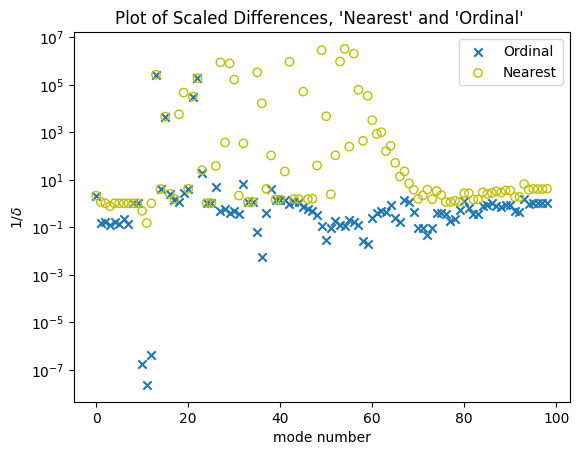

In [7]:
low_evals, _ = IncS3D.spectrum(1.2, 0.7, M=50)
high_evals, high_emodes = IncS3D.spectrum(1.2, 0.7, M=70)
low_evals = low_evals[np.argsort(-np.real(low_evals))]
# low_evals = low_evals[1:]
high_evals = high_evals[np.argsort(-np.real(high_evals))]
# high_evals = high_evals[:-1]

fig, d_ordinal, d_nearest = Utilities.plot_scaled_diff(low_evals, high_evals)
print(low_evals[:5])
print(high_evals[:5])
resolve_score = 0
for i in range(len(d_ordinal)//2):
    if np.abs(d_ordinal[i] - d_nearest[i]) < 0.001:
        resolve_score += 1 / len(d_ordinal)
print("Resolultion Score:", np.round(resolve_score,4))

In [10]:
print(low_evals[:5])
print(high_evals[6:12])

[1.18720249e+04-0.00000000e+00j 5.71384520e+02+0.00000000e+00j
 1.13957059e+01-2.37507615e-05j 9.57681268e+00-5.44211895e+00j
 9.57681121e+00+5.44214238e+00j]
[ 1.46430690e+01+5.43116549e+01j  1.46430663e+01-5.43116590e+01j
  1.05164626e-11+0.00000000e+00j  8.09927537e-12+0.00000000e+00j
 -1.59404035e-05+1.92471762e-06j -4.71978035e-05-1.69325853e-05j]


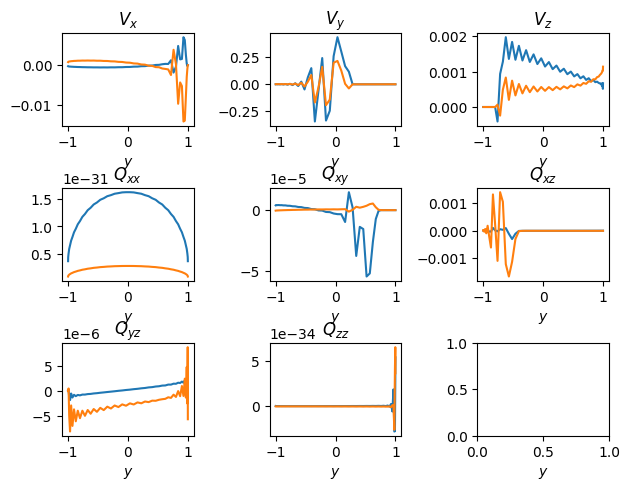

In [ ]:
_ = Utilities.plot_modes(4, Y, high_emodes, M)

LHS Cond =  554712773943.4908
RHS Cond =  inf
LHS Cond =  8797533330482.023
RHS Cond =  inf
Resolultion Score: 0.5


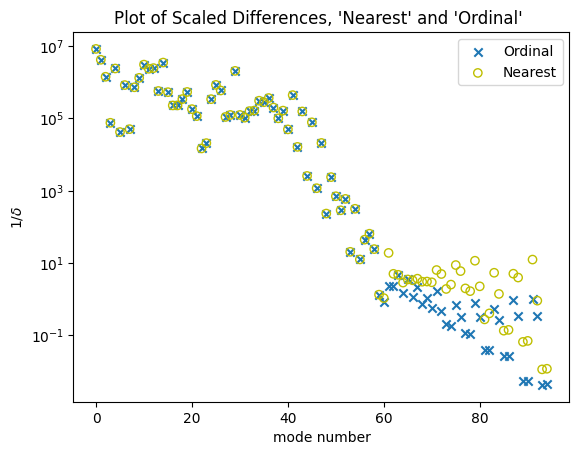

In [ ]:
low_evals, _ = ShearSpectrum2D.spectrum(np.sqrt(kx*kx+kz*kz), 0.5, 1, a, M=50)
high_evals, high_emodes = ShearSpectrum2D.spectrum(np.sqrt(kx*kx+kz*kz), 0.5, 1, a, M=70)
low_evals = low_evals[np.argsort(-np.real(low_evals))]
high_evals = high_evals[np.argsort(-np.real(high_evals))]

fig, d_ordinal, d_nearest = Utilities.plot_scaled_diff(low_evals, high_evals)

resolve_score = 0
for i in range(len(d_ordinal)//2):
    if np.abs(d_ordinal[i] - d_nearest[i]) < 0.001:
        resolve_score += 1 / len(d_ordinal)
print("Resolultion Score:", np.round(resolve_score,4))

### Analyze the spectra generated by the 3D equations

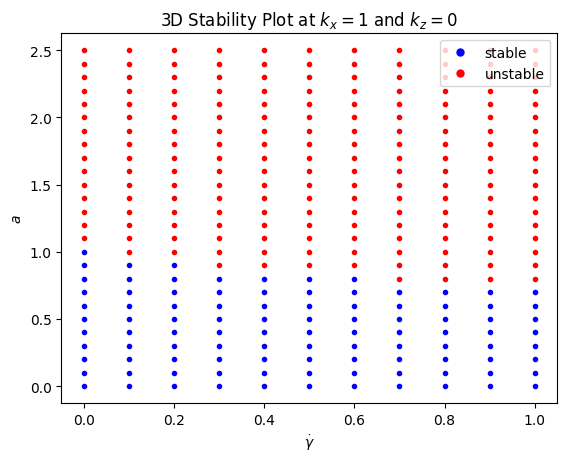

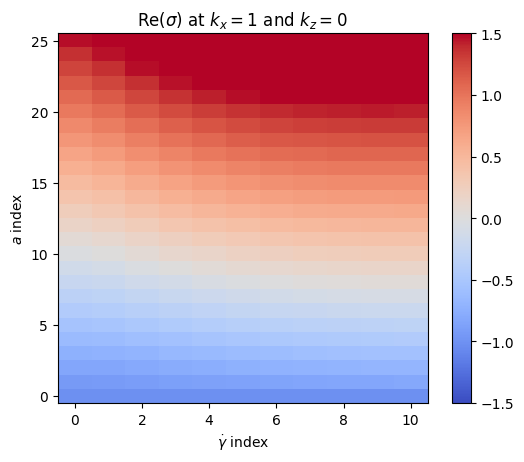

In [ ]:
import os

gdl,gdr,gdn = 0.0, 1.0, 11
gds = np.linspace(gdl, gdr, gdn)
al, ar, an = 0.0, 2.5, 26
acts = np.linspace(al, ar, an)

folder_name = "3D-shear-new-kx1-kz0.0"
SIGMA = np.zeros((an, gdn))

acts = np.load(os.path.join("data", folder_name, "acts.npy"))
gds = np.load(os.path.join("data", folder_name, "gds.npy"))
gdn = len(gds)
an = len(acts)

fig = plt.figure()
for i in range(gdn):
    for j in range(an):
        accepted = []
        low_res_evs = np.load(os.path.join("data", folder_name, "M-50", f"gd-{i}-a-{j}.npy"))
        high_res_evs = np.load(os.path.join("data",folder_name, "M-70", f"gd-{i}-a-{j}.npy"))
        low_res_evs = low_res_evs[np.argsort(-np.real(low_res_evs))]
        high_res_evs = high_res_evs[np.argsort(-np.real(high_res_evs))]
        # d_ordinal, d_nearest = Utilities.calc_scaled_diff(low_res_evs, high_res_evs)
        # for k in range(len(d_ordinal)//2):
        #     if np.abs(d_ordinal[k] - d_nearest[k]) < 0.0001:# and np.abs(d_ordinal[k])<0.0001:
        #         accepted.append(low_res_evs[k])
        # accepted = np.array(accepted)
        # accepted = accepted[np.argsort(-np.real(accepted))]
        accepted = Utilities.prune_evs(low_res_evs, high_res_evs, eps=0.01)
        accepted = accepted[np.argsort(-np.real(accepted))]
        # with np.printoptions(precision=3, suppress=True):
        #     print(np.real(accepted)[0:3])
        if len(accepted)==0: 
            continue
        # print(accepted[0:5])
        c = "red" if accepted[0].real > 0 else "blue"
        SIGMA[j,i] = accepted[0].real
        plt.plot(gds[i],acts[j],".",color=c, picker=True)
blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                      markersize=10, label='stable')
red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                      markersize=10, label='unstable')
plt.legend(handles=[blue_dot, red_dot])
plt.xlabel("$\dot\gamma$")
plt.ylabel("$a$")
plt.title(f"3D Stability Plot at $k_x=1$ and $k_z=0$")
plt.show()

fig=plt.figure()
plt.imshow(SIGMA,cmap='coolwarm',aspect=gdn/an, vmin=-1.5, vmax=1.5, origin='lower')
plt.colorbar()
plt.xlabel("$\dot\gamma$ index")
plt.ylabel("$a$ index")
plt.title("Re($\sigma$) at $k_x=1$ and $k_z=0$")
plt.show()

In [ ]:
import os

kz = 0
# These grid values were used by Wan to do all her calculations
kxl,kxr,kxn = 0.0, 4.0, 11
kxs = np.linspace(kxl,kxr,kxn)
al, ar, an = 0.0, 4.0, 11
acts = np.linspace(al, ar, an)

folder_name = "3D-shear-new-gd0-kz0"
SIGMA = np.zeros((an, kxn))

fig = plt.figure()
for i in range(kxn):
    for j in range(an):
        accepted = []
        low_res_evs = np.load(os.path.join("data", folder_name, "M-50", f"kx-{kxs[i]}-a-{acts[j]}.npy"))
        high_res_evs = np.load(os.path.join("data",folder_name, "M-70", f"kx-{kxs[i]}-a-{acts[j]}.npy"))
        low_res_evs = low_res_evs[np.argsort(-np.real(low_res_evs))]
        high_res_evs = high_res_evs[np.argsort(-np.real(high_res_evs))]
        clean_evs = Utilities.prune_evs(low_res_evs, high_res_evs)
        c = "red" if clean_evs[0].real > 0 else "blue"
        SIGMA[j,i] = clean_evs[0].real
        print(clean_evs[0].real)
        plt.plot(kxs[i],acts[j],".",color=c, picker=True, alpha=1)
blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                      markersize=10, label='stable')
red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                      markersize=10, label='unstable')
plt.legend(handles=[blue_dot, red_dot])
plt.show()

fig=plt.figure()
plt.imshow(SIGMA,cmap='coolwarm',aspect=kxn/an, vmin=-3, vmax=3, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
kx=10; a=4
ev_1, _ = ZeroShearSpectrum3D.spectrum(kx=kx, a=a, M=50)
ev_2, _ = ShearSpectrum3D.spectrum(kx=kx, kz=0, gd=0, a=a, M=50)

Spectral Operator Matrix Condition Num: 1.2341617583462124e+22
Spectral Operator Condition Number:1.08E+22


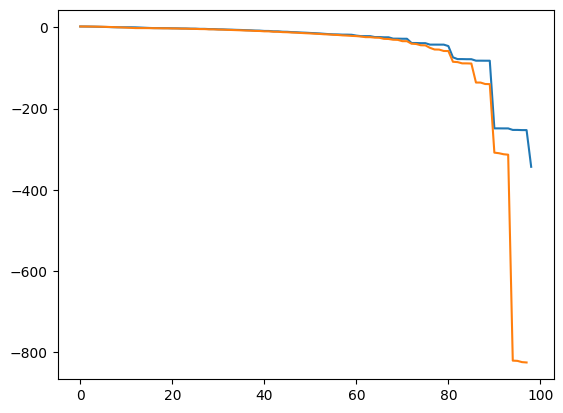

In [ ]:
ev_1 = ev_1[np.argsort(-np.real(ev_1))]
ev_2 = ev_2[np.argsort(-np.real(ev_2))]
plt.figure()
plt.plot(np.real(ev_1))
plt.plot(np.real(ev_2))

In [ ]:
al, ar, an = 0.0, 4.0, 11
a = np.linspace(al, ar, an)
max_real_evs_pruned = np.zeros(len(a), dtype=np.complex128)
max_real_evs_diff = np.zeros(len(a), dtype=np.complex128)

for k in range(len(a)):
    print(f"Done: {k+1}/{len(a)}", end=" | ")
    low_evs, _ = ShearSpectrum3D.spectrum(kx=0.0, kz=1.0, gd=1.2, a=a[k], M=70)
    high_evs, _ = ShearSpectrum3D.spectrum(kx=0.0, kz=1.0, gd=1.2, a=a[k], M=90)

    # Scaled diff approach
    # d_ordinal, d_nearest = Utilities.calc_scaled_diff(low_evs, high_evs)
    # accepted = []
    # for kk in range(len(d_ordinal)//2):
    #     # Require well-resolution and low-error at the same time
    #     if np.abs(d_ordinal[kk] - d_nearest[kk]) < 0.0001 and np.abs(d_ordinal[kk])<0.1:
    #         accepted.append(low_res_evs[kk])
    # accepted = np.array(accepted)
    # accepted = accepted[np.argsort(-np.real(accepted))]
    # if len(accepted)>0:
    #     print("Scale Diff:", acceoted[0])
    #     max_real_evs_diff[k] = accepted[0]
                
    # Two pointer approach
    pruned_evs = Utilities.prune_evs(low_evs, high_evs)
    pruned_evs = pruned_evs[np.argsort(-pruned_evs.real)]
    if len(pruned_evs)>0:
        print("Pruning: ", pruned_evs[0])
        max_real_evs_pruned[k] = pruned_evs[0]
    print()

Done: 1/11 | 
Done: 2/11 | Pruning:  (-0.8972518128966875+0.8304024774605109j)

Done: 3/11 | 
Done: 4/11 | 
Done: 5/11 | 
Done: 6/11 | Pruning:  (-16.44686057950695+1.2365018093768396e-07j)

Done: 7/11 | 
Done: 8/11 | 
Done: 9/11 | 
Done: 10/11 | Pruning:  (-2.670631866027852+6.101580502933196e-10j)

Done: 11/11 | Pruning:  (1.0917944098255163-1.5381561212642608e-11j)



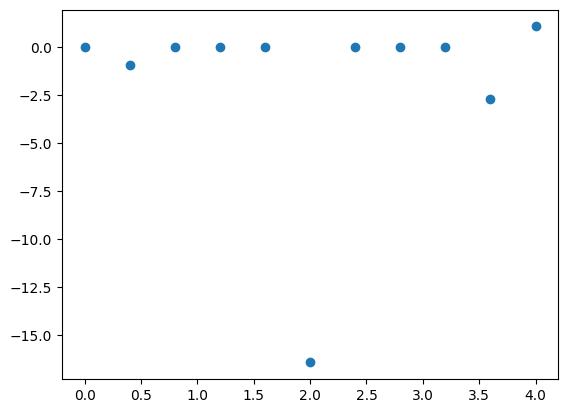

In [ ]:
plt.scatter(a, max_real_evs_pruned.real)
# plt.scatter(a, max_real_evs_diff.real)

In [ ]:
import os
kx = 1
kz = 1
gdl,gdr,gdn = 0.0, 1.0, 11
gds = np.linspace(gdl, gdr, gdn)
al, ar, an = 0.0, 4.0, 11
a = np.linspace(al, ar, an)

folder_name = "3D-shear-new-kx1-kz1"
max_real_evs = np.zeros(len(a), dtype=np.complex128)
max_real_evs_low = np.zeros(len(a), dtype=np.complex128)
max_real_evs_high = np.zeros(len(a), dtype=np.complex128)

gd_num = 5
for k in range(an):
    accepted = []
    low_res_evs = np.load(os.path.join("data", folder_name, "M-50", f"gd-{gds[gd_num]}-a-{a[k]}.npy"))
    high_res_evs = np.load(os.path.join("data",folder_name, "M-70", f"gd-{gds[gd_num]}-a-{a[k]}.npy"))
    low_res_evs = low_res_evs[np.argsort(-low_res_evs.real)]
    high_res_evs = high_res_evs[np.argsort(-high_res_evs.real)]
    max_real_evs_low[k] = low_res_evs[0] 
    max_real_evs_high[k] = high_res_evs[0]
    evs = Utilities.prune_evs(low_res_evs, high_res_evs)
    evs = evs[np.argsort(-evs.real)]
    max_real_evs[k] = evs[0]

In [ ]:
gds[gd_num]

0.5

### Plot for Multiple values of $k_x$ with $k_z=0$ (because having $k_z\neq 0$ causes numerical instabilities)

In [ ]:
import os 

folder_name = "3D-shear-new-kx_0-20_kz0.0"

def plot_spec_mat(folder_name, vmin=-2.0, vmax=2.0):
    a = np.load(os.path.join("data", folder_name, "acts.npy"))
    gd = np.load(os.path.join("data", folder_name, "gds.npy"))
    kx = np.load(os.path.join("data", folder_name, "kxs.npy"))
    spec_mat = np.load(os.path.join("data", folder_name, "spectra-mat.npy"))

    # SIGMA stores the eigenvalues with max real parts over all kx's for each (gd, a)
    SIGMA = np.zeros((len(a), len(gd)), dtype=np.complex128)

    plt.figure()
    for i in range(len(gd)):
        for j in range(len(a)):
            max_ev_k = []
            for k in range(len(kx)):
                # Assume that these eigenvalues were already sorted by their real parts
                low_ev = spec_mat[k,i,j,0,:]
                high_ev = spec_mat[k,i,j,1,:]
                pruned_ev = Utilities.prune_evs(low_ev, high_ev)
                if len(pruned_ev) > 0:
                    max_ev_k.append(pruned_ev[0])
            max_ev_k = np.array(max_ev_k)
            if i in [0, 4, 7, 10] and j==10:
            # if j in [0,4,7,10] and i==4:
                plt.plot(kx, max_ev_k.real, label=f"$\dot\gamma={np.round(gd[i],4)}$, $a={np.round(a[j], 4)}$")
            max_ev_k = max_ev_k[np.argsort(-max_ev_k.real)]
            SIGMA[j,i] = max_ev_k[0].real
    plt.legend(loc='lower left')
    plt.xlabel("$k$")
    plt.ylabel("max(Re($\sigma$))")
    plt.title("Spectra of system under different $k_x$ values")
    plt.show() 

    for i in range(len(gd)):
        for j in range(len(a)):
            c = "red" if SIGMA[j,i] > 0 else "blue"
            plt.plot(gd[i],a[j],".",color=c, picker=True)
    blue_dot = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                        markersize=10, label='stable')
    red_dot = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                        markersize=10, label='unstable')
    plt.legend(handles=[blue_dot, red_dot])
    plt.xlabel("$\dot\gamma$")
    plt.ylabel("$a$")
    plt.title(f"3D Stability with $k_z=0$ and $k_x\in[1,20]$")
    plt.show()

    fig=plt.figure()
    if vmin==None or vmax==None:
        plt.imshow(SIGMA.real,cmap='coolwarm',aspect=len(gd)/len(a), origin='lower')
    else:
        plt.imshow(SIGMA.real,cmap='coolwarm',aspect=len(gd)/len(a), vmin=vmin, vmax=vmax, origin='lower')
    plt.colorbar()
    plt.xlabel("$\dot\gamma$")
    plt.ylabel("$a$")
    plt.title("Re($\sigma$) at $k_x\in[1,20]$ and $k_z=0$")
    plt.xticks(np.arange(len(gd)), np.round(gd,2))
    plt.yticks(np.arange(len(a)), np.round(a,2))
    plt.show()

    return SIGMA

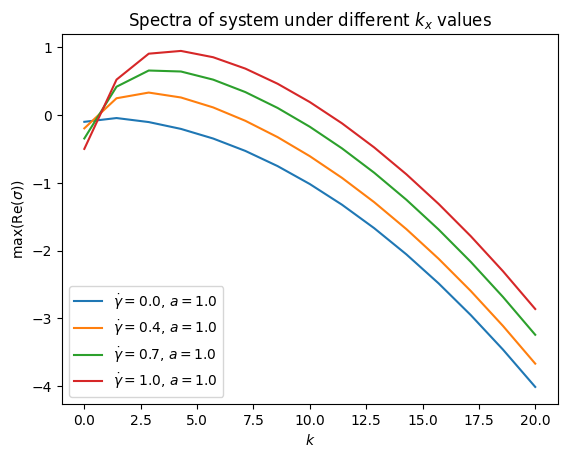

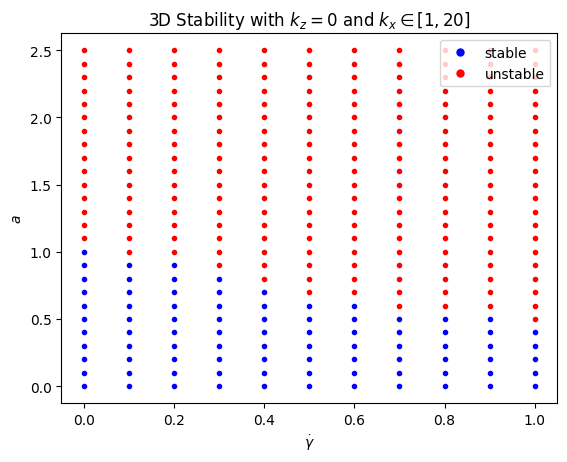

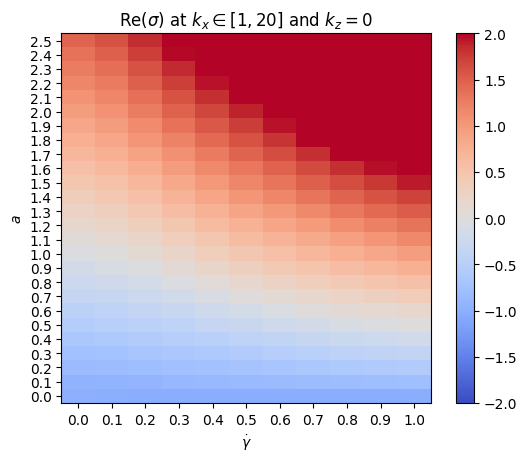

In [ ]:
plot_spec_mat("3D-shear-new-kx_0-20_kz0.0");

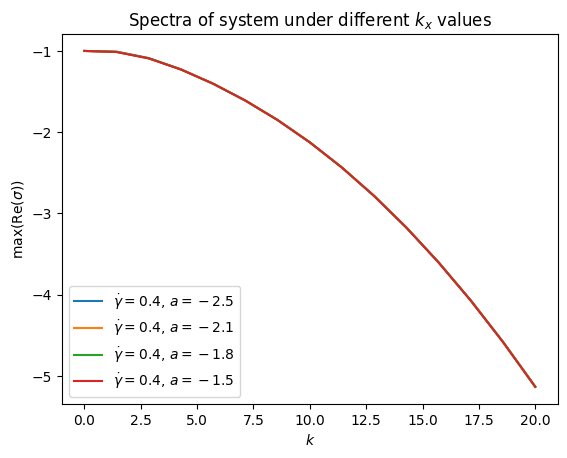

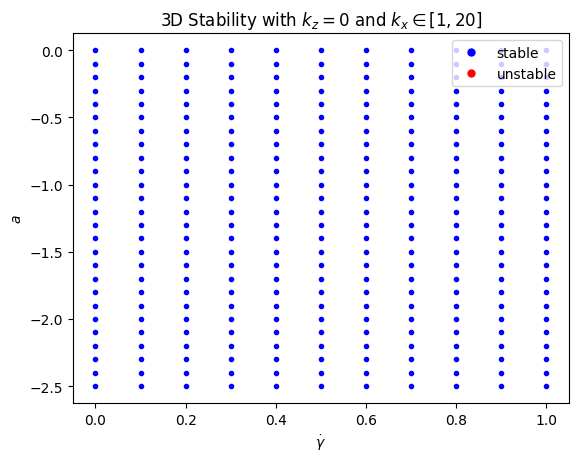

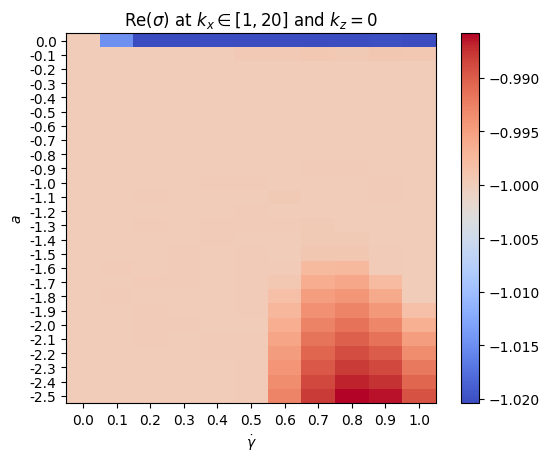

[[-1.        +0.j -0.99995831+0.j -0.99999856+0.j -0.99993218+0.j
  -0.9999947 +0.j -0.99984258+0.j -0.99280481+0.j -0.9880092 +0.j
  -0.98587075+0.j -0.98636584+0.j -0.9893254 +0.j]
 [-1.        +0.j -1.        +0.j -0.99991336+0.j -0.99998196+0.j
  -0.99997694+0.j -0.99983646+0.j -0.99344885+0.j -0.98882979+0.j
  -0.986866  +0.j -0.98752604+0.j -0.99063339+0.j]
 [-1.        +0.j -0.99998151+0.j -0.99997349+0.j -0.99993414+0.j
  -0.9999994 +0.j -0.99977713+0.j -0.99413393+0.j -0.98970099+0.j
  -0.98792026+0.j -0.98875187+0.j -0.99201185+0.j]
 [-1.        +0.j -0.99999885+0.j -0.99998176+0.j -0.99997725+0.j
  -0.99981829+0.j -0.99985865+0.j -0.99486436+0.j -0.99062778+0.j
  -0.98903906+0.j -0.99004925+0.j -0.99346663+0.j]
 [-1.        +0.j -0.99999843+0.j -0.99984164+0.j -0.99999937+0.j
  -0.99983982+0.j -0.99988832+0.j -0.99564465+0.j -0.99161577+0.j
  -0.9902286 +0.j -0.9914246 +0.j -0.99500418+0.j]
 [-1.        +0.j -0.99998011+0.j -0.99987243+0.j -0.99982572+0.j
  -0.9999992 +0.j -

In [ ]:
SIGMA = plot_spec_mat("3D-shear-new-kx_0-20_kz0.0-neg-act", vmin=None, vmax=None)
print(SIGMA)

In [ ]:
kx, gd, a = 1.4, 0.6, 2.5
store = np.zeros((4,10), dtype=np.complex)
for kz in [0.1, 0.5, 1.0, 1.5]:
    low_evals, _ = ShearSpectrum3D.spectrum(kx, kz, gd, a, M=70)
    high_evals, high_modes = ShearSpectrum3D.spectrum(kx, kz, gd, a, M=80)
    low_evals = low_evals[np.argsort(-np.real(low_evals))]
    high_evals = high_evals[np.argsort(-np.real(high_evals))]
    pruned, _, _= Utilities.prune_evs(low_evals, high_evals, eps=1e-3)